In [1]:
import sys

print(sys.version)

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (
    Input,
    Dense,
    Reshape,
    Flatten,
    Dropout,
    BatchNormalization,
    Activation,
    ZeroPadding2D,
    LeakyReLU,
    UpSampling2D,
    Conv2D,
    MaxPooling2D,
    Concatenate,
    GaussianNoise,
    GaussianDropout,
    Lambda,
)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import pathlib

import time

import math

# import cv2
import h5py
import pickle

# import PIL

In [3]:
print("Tensorflow version: ", tf.VERSION)  # 1.13.1
print("Keras version: ", tf.keras.__version__)  # 2.2.4-tf

tf.enable_eager_execution()
print("Is eager execution enabled: ", tf.executing_eagerly())
print("Is there a GPU available: ", tf.test.is_gpu_available())

Tensorflow version:  1.15.2
Keras version:  2.2.4-tf
Is eager execution enabled:  True
Is there a GPU available:  True


In [4]:
filename = "vgg_85_year"

path_train_tfrecord = "/data/fp85_train.tfrecord"
path_test_tfrecord = "/data/fp85_test.tfrecord"

predict_only = True
predict_test_only = False

In [5]:
path_model = filename + ".h5"

dir_model = os.path.dirname(path_model)
pathlib.Path(dir_model).mkdir(parents=True, exist_ok=True)

In [6]:
n_examples = {
    key: sum(1 for _ in tf.data.TFRecordDataset(path, compression_type="GZIP"))
    for key, path in {"train": path_train_tfrecord, "test": path_test_tfrecord}.items()
}
n_examples

{'train': 12736, 'test': 3309}

In [7]:
# https://medium.com/@moritzkrger/speeding-up-keras-with-tfrecord-datasets-5464f9836c36

EPOCHS = 100

BUFFER_SIZE = 1024
BATCH_SIZE = 8

IMAGE_DIMS = (28, 28, 6)
# LABEL_DIM = 9


def _parse_function(example_proto):
    # Create a description of the features.
    feature_description = {
        "floorplan": tf.io.FixedLenFeature(
            [28, 28, 6], tf.float32, default_value=tf.zeros([28, 28, 6], tf.float32)
        ),
        "plan_id": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "norm_year": tf.io.FixedLenFeature([], tf.float32, default_value=-1.0),
        "sido": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        "norm_area": tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
        "num_rooms": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        "num_baths": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        "brands": tf.io.FixedLenFeature(
            [12], tf.int64, default_value=tf.zeros([12], tf.int64)
        ),
    }

    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    return (parsed_example["floorplan"], parsed_example["norm_year"])


def _onehot_fp(fp, *rest):
    """
    Replace unit layer with outdoor layer and restrict function space layers indoor
    """
    fp_func = fp[:, :, 1:6] * tf.reshape(fp[:, :, 0], (28, 28, 1))
    fp_out = tf.reshape(1 - fp[:, :, 0], (28, 28, 1))
    return (tf.concat([fp_out, fp_func], axis=2), *rest)


def _rescale_fp(fp, *rest):
    """
    Rescale from [0, 1] to [-1, 1]
    """
    return (fp * 2 - 1, *rest)


# def _onehot_sido(fp, sido, *rest):
#     """
#     Make sido label into one-hot vector
#     """
#     return (fp, tf.one_hot(sido, LABEL_DIM), *rest)


def create_dataset(filepath):

    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type="GZIP")

    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=4)

    # make the floorplan one-hot-ish
    dataset = dataset.map(_onehot_fp, num_parallel_calls=4)

    # rescale to [-1, 1]
    dataset = dataset.map(_rescale_fp, num_parallel_calls=4)

    #     # make sido one-hot
    #     dataset = dataset.map(_onehot_sido, num_parallel_calls=4)

    # This dataset will go on forever
    dataset = dataset.repeat()

    # Set the number of datapoints you want to load and shuffle
    dataset = dataset.shuffle(BUFFER_SIZE)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)

    return dataset


train_dataset = create_dataset(path_train_tfrecord)
test_dataset = create_dataset(path_test_tfrecord)
train_dataset

<DatasetV1Adapter shapes: ((?, 28, 28, 6), (?,)), types: (tf.float32, tf.float32)>

# SmallerVGGNet, with noise layer added

Source:
https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

In [8]:
class SmallerVGGNet_regression:
    @staticmethod
    def build(width, height, depth):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # add black & white noise to input data
        if chanDim == -1:
            noiseShape = (height, width, 1)
        else:
            noiseShape = (1, height, width)

        model.add(Dropout(0.2, noise_shape=noiseShape, input_shape=inputShape))  # gray
        model.add(GaussianNoise(0.1))  # 0-centered noise

        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(1))
        model.add(Activation("sigmoid"))

        return model

In [9]:
model = SmallerVGGNet_regression.build(
    width=IMAGE_DIMS[1], height=IMAGE_DIMS[0], depth=IMAGE_DIMS[2],  # classes=LABEL_DIM,
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 28, 28, 6)         0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 28, 28, 6)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        1760      
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 32)          0

In [10]:
model.compile(optimizer="RMSprop", loss="mean_squared_error")

In [11]:
if not predict_only:
    monitor = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=100, verbose=1
    )

    history = model.fit(
        train_dataset,
        epochs=1000,
        steps_per_epoch=n_examples["train"] // BATCH_SIZE,
        validation_data=test_dataset,
        validation_steps=n_examples["test"] // BATCH_SIZE,
        callbacks=[monitor],
    )

Train for 1592 steps, validate for 413 steps
Epoch 1/1000
1592/1592 [==============================] - 12s 8ms/step - loss: 0.0406 - val_loss: 0.0297
Epoch 2/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0139 - val_loss: 0.0149
Epoch 3/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0115 - val_loss: 0.0117
Epoch 4/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0108 - val_loss: 0.0344
Epoch 5/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0102 - val_loss: 0.0150
Epoch 6/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0097 - val_loss: 0.0168
Epoch 7/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0095 - val_loss: 0.0082
Epoch 8/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0091 - val_loss: 0.0133
Epoch 9/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0088 - val_loss: 0.0145
Epoch 10/1

Epoch 78/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 79/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0046 - val_loss: 0.0068
Epoch 80/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 81/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0047 - val_loss: 0.0062
Epoch 82/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0047 - val_loss: 0.0064
Epoch 83/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0047 - val_loss: 0.0058
Epoch 84/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0046 - val_loss: 0.0079
Epoch 85/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0048 - val_loss: 0.0072
Epoch 86/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0047 - val_loss: 0.0061
Epoch 87/1000
1592/1592 [=====================

1592/1592 [==============================] - 10s 6ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 155/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 156/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0041 - val_loss: 0.0060
Epoch 157/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0040 - val_loss: 0.0071
Epoch 158/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 159/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 160/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0041 - val_loss: 0.0060
Epoch 161/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0042 - val_loss: 0.0060
Epoch 162/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 163/1000
1592/1592 [==========================

1592/1592 [==============================] - 10s 6ms/step - loss: 0.0037 - val_loss: 0.0056
Epoch 231/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 232/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 233/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0037 - val_loss: 0.0057
Epoch 234/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 235/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0038 - val_loss: 0.0054
Epoch 236/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0036 - val_loss: 0.0058
Epoch 237/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 238/1000
1592/1592 [==============================] - 10s 6ms/step - loss: 0.0037 - val_loss: 0.0059
Epoch 239/1000
1592/1592 [==========================

In [12]:
if not predict_only:
    # save the loss
    H = history
    N = len(H.history["loss"])

    df_history = pd.DataFrame(
        {
            "epoch": np.arange(1, N + 1),
            "train_loss": H.history["loss"],
            "val_loss": H.history["val_loss"],
        }
    )
    df_history = df_history.set_index("epoch")
    df_history.to_csv(filename + "_loss.csv")

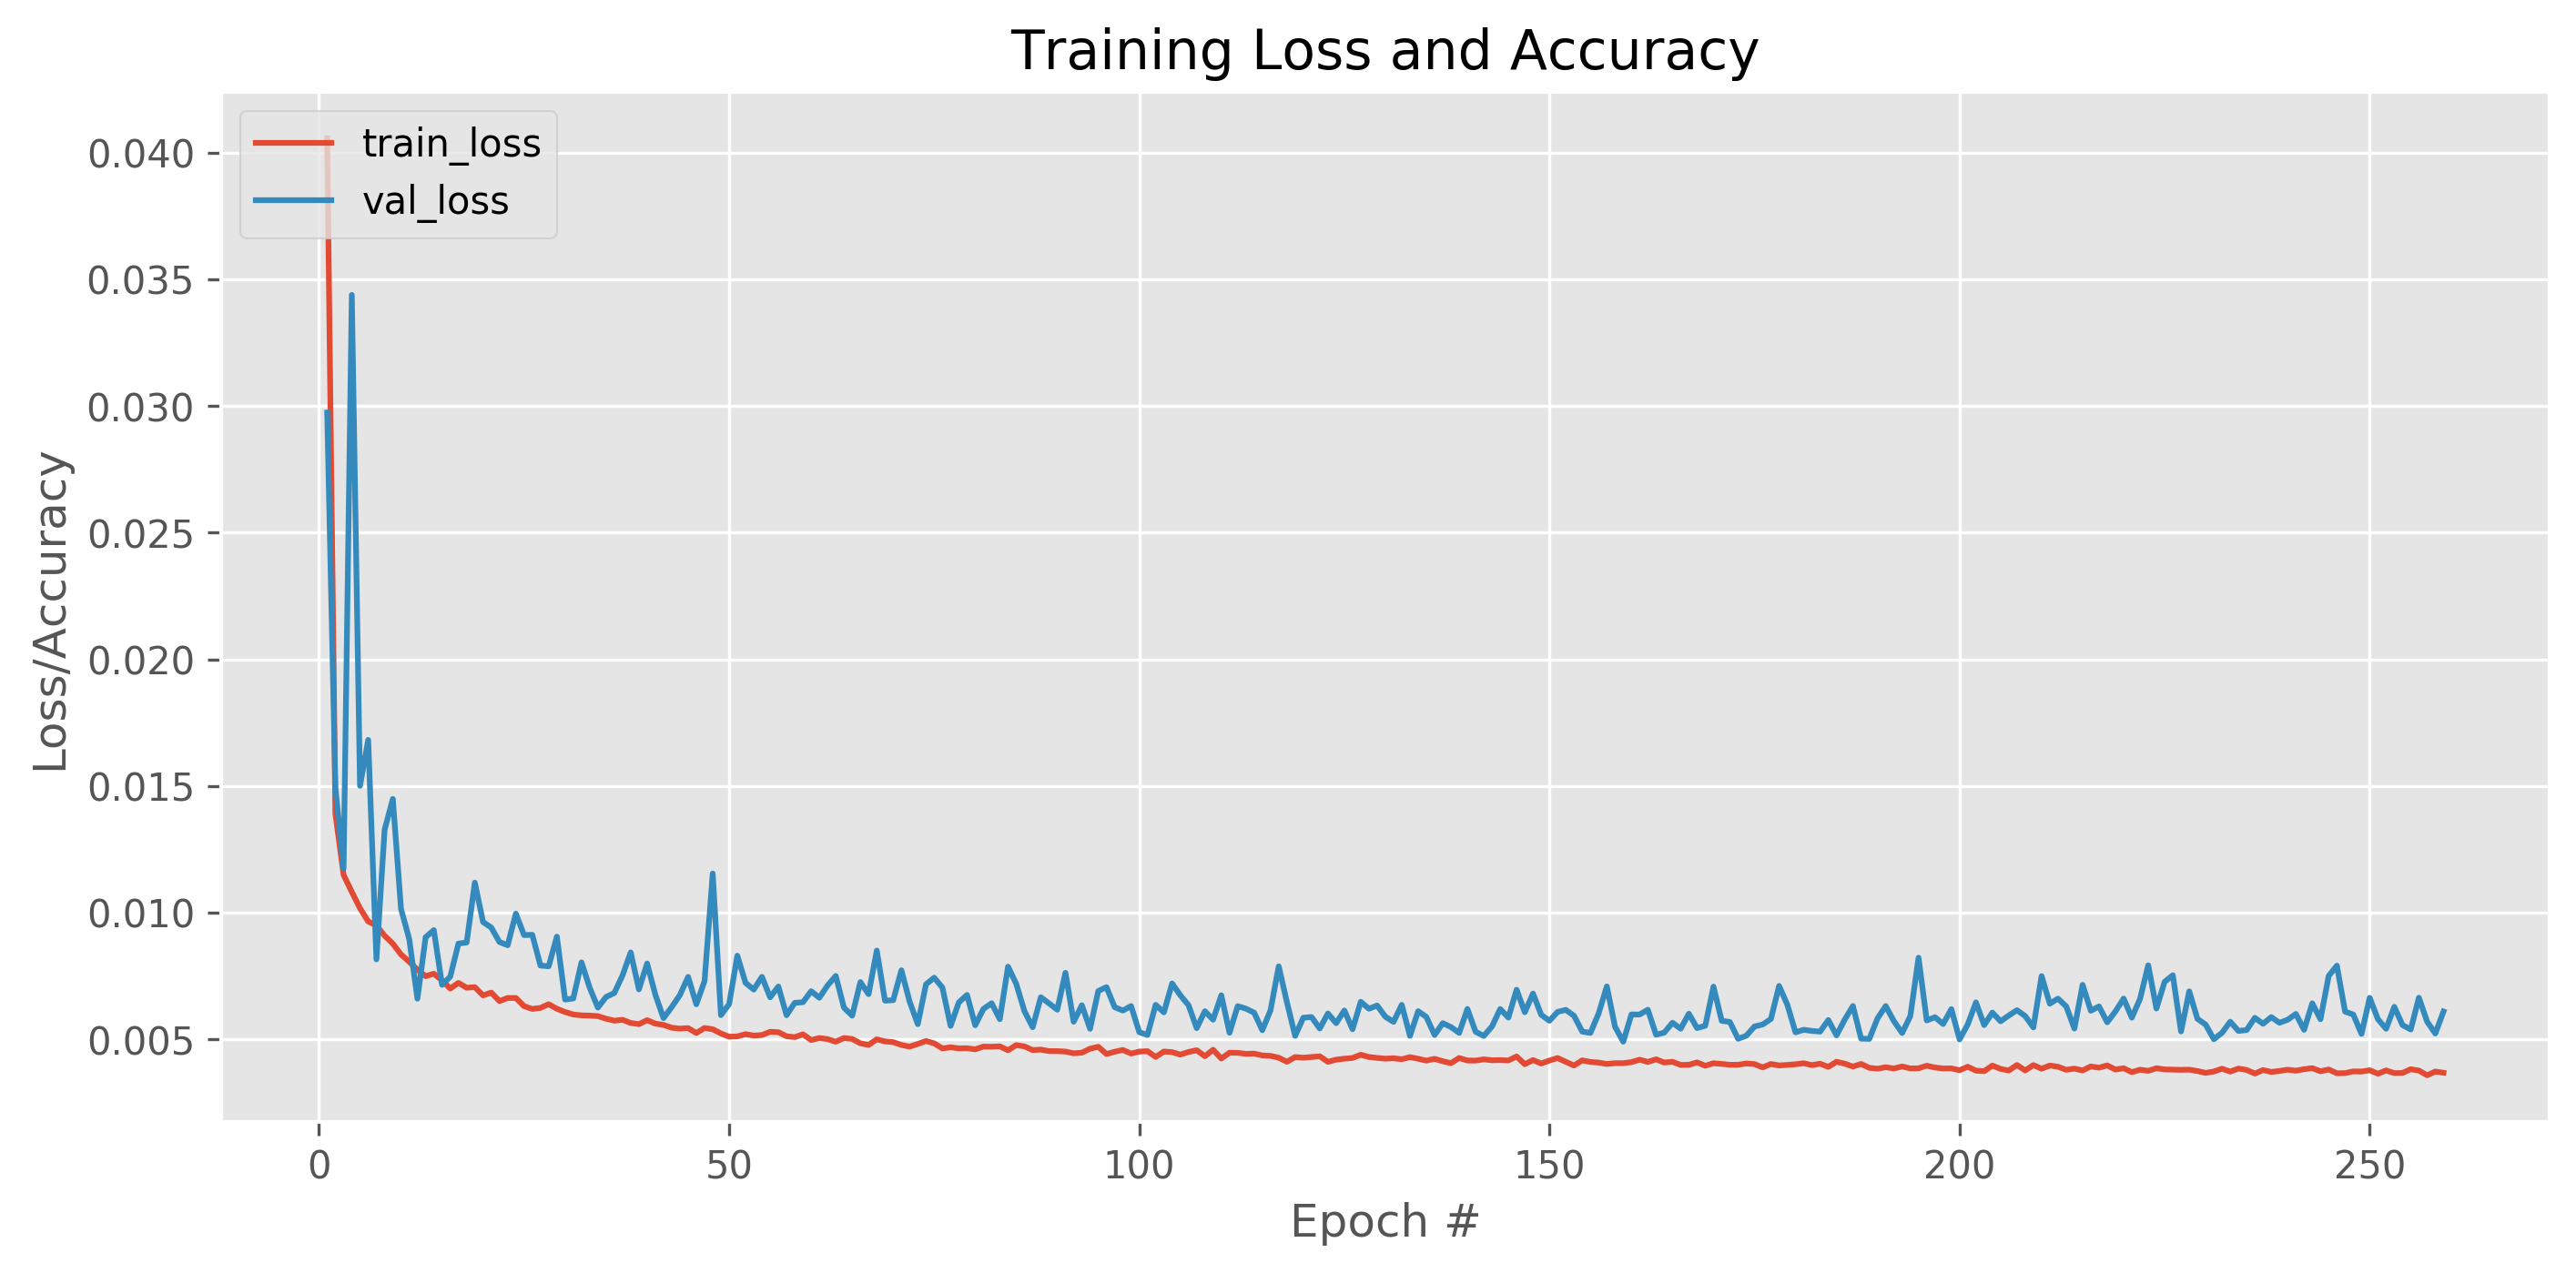

In [13]:
# plot the training loss

df_history = pd.read_csv(filename + "_loss.csv", index_col="epoch")

plt.style.use("ggplot")
fig = plt.figure(figsize=(11, 5), dpi=300)
plt.plot(df_history.index, df_history["train_loss"], label="train_loss")
plt.plot(df_history.index, df_history["val_loss"], label="val_loss")

# plt.ylim(top=0.05)

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

plt.savefig(
    filename + ".pdf", bbox_inches="tight", pad_inches=0,
)
plt.savefig(
    filename + ".png", bbox_inches="tight", pad_inches=0,
)

In [14]:
if not predict_only:
    print("loss:    ", H.history["loss"][-1])
    print("val_loss:", H.history["val_loss"][-1])

loss:     0.0036812442725127383
val_loss: 0.006099551860733549


In [15]:
if not predict_only:
    with h5py.File(path_model, "w") as file:
        weight = model.get_weights()
        for i in range(len(weight)):
            file.create_dataset("weight" + str(i), data=weight[i])

In [16]:
# !ls -al {path_model}

In [17]:
with h5py.File(path_model,'r') as file:
    weight = []
    for i in range(len(file.keys())):
        weight.append(file['weight'+str(i)][:])
        
model.set_weights(weight)
# weight

In [18]:
def _parse_predict_function(example_proto):
    # Create a description of the features.
    feature_description = {
        "floorplan": tf.io.FixedLenFeature(
            [28, 28, 6], tf.float32, default_value=tf.zeros([28, 28, 6], tf.float32)
        ),
        "plan_id": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "norm_year": tf.io.FixedLenFeature([], tf.float32, default_value=-1.0),
        "sido": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        "norm_area": tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
        "num_rooms": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        "num_baths": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
        "brands": tf.io.FixedLenFeature(
            [12], tf.int64, default_value=tf.zeros([12], tf.int64)
        ),
    }

    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    #     return (parsed_example["floorplan"],)
    return (
        parsed_example["floorplan"],
        parsed_example["norm_year"],
        parsed_example["plan_id"],
    )


def create_predict_dataset(filepath):

    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type="GZIP")

    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_predict_function, num_parallel_calls=4)

    # make the floorplan one-hot-ish
    dataset = dataset.map(_onehot_fp, num_parallel_calls=4)

    # rescale to [-1, 1]
    dataset = dataset.map(_rescale_fp, num_parallel_calls=4)

    # make sido one-hot
#     dataset = dataset.map(_onehot_sido, num_parallel_calls=4)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [19]:
if predict_test_only:
    paths_predict_tfrecord = [path_test_tfrecord]
else:
    paths_predict_tfrecord = [path_train_tfrecord, path_test_tfrecord]

In [20]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
n_examples["predict"] = sum(
    1 for _ in tf.data.TFRecordDataset(paths_predict_tfrecord, compression_type="GZIP")
)

predictions = model.predict(
    predict_dataset, steps=n_examples["predict"] // BATCH_SIZE + 1
)

In [21]:
predict_dataset = create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

ids = []
true_label = []

for batch in iter:
    true_label.extend(batch[1].numpy())
    ids.extend(batch[-1].numpy())

ids = [x.decode() for x in ids]
true_label = np.asarray(true_label)
ids[:10], true_label[:10]

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


(['1298_116',
  '1303_107',
  '1307_114',
  '28_107',
  '881_101',
  '1321_106A',
  '1327_105',
  '14671_109C',
  '9765_107A',
  '9765_107D'],
 array([0.28, 0.28, 0.28, 0.3 , 0.44, 0.34, 0.34, 0.72, 0.7 , 0.7 ],
       dtype=float32))

In [22]:
df = pd.DataFrame(
    zip(ids, true_label, predictions[:,0]),
    columns=["ID", "true", "prediction"],
)
df

,ID,true,prediction
0,1298_116,0.28,0.206083
1,1303_107,0.28,0.200108
2,1307_114,0.28,0.208295
3,28_107,0.30,0.315332
4,881_101,0.44,0.417654
...,...,...,...
16040,105110_110B,0.88,0.862907
16041,22474_108B,0.74,0.739729
16042,22474_114,0.74,0.739729
16043,102372_111E,0.82,0.790503


In [23]:
df.corr()

,true,prediction
true,1.000000,0.950648
prediction,0.950648,1.000000


In [24]:
corr_year = df['true'].corr(df['prediction'])
r2_text = format(corr_year**2, '.3f')
r2_text = '$r^2 = ' + r2_text + '$'

if predict_test_only: 
    r2_text += '\n(Test dataset only)'
    
r2_text

'$r^2 = 0.904$'

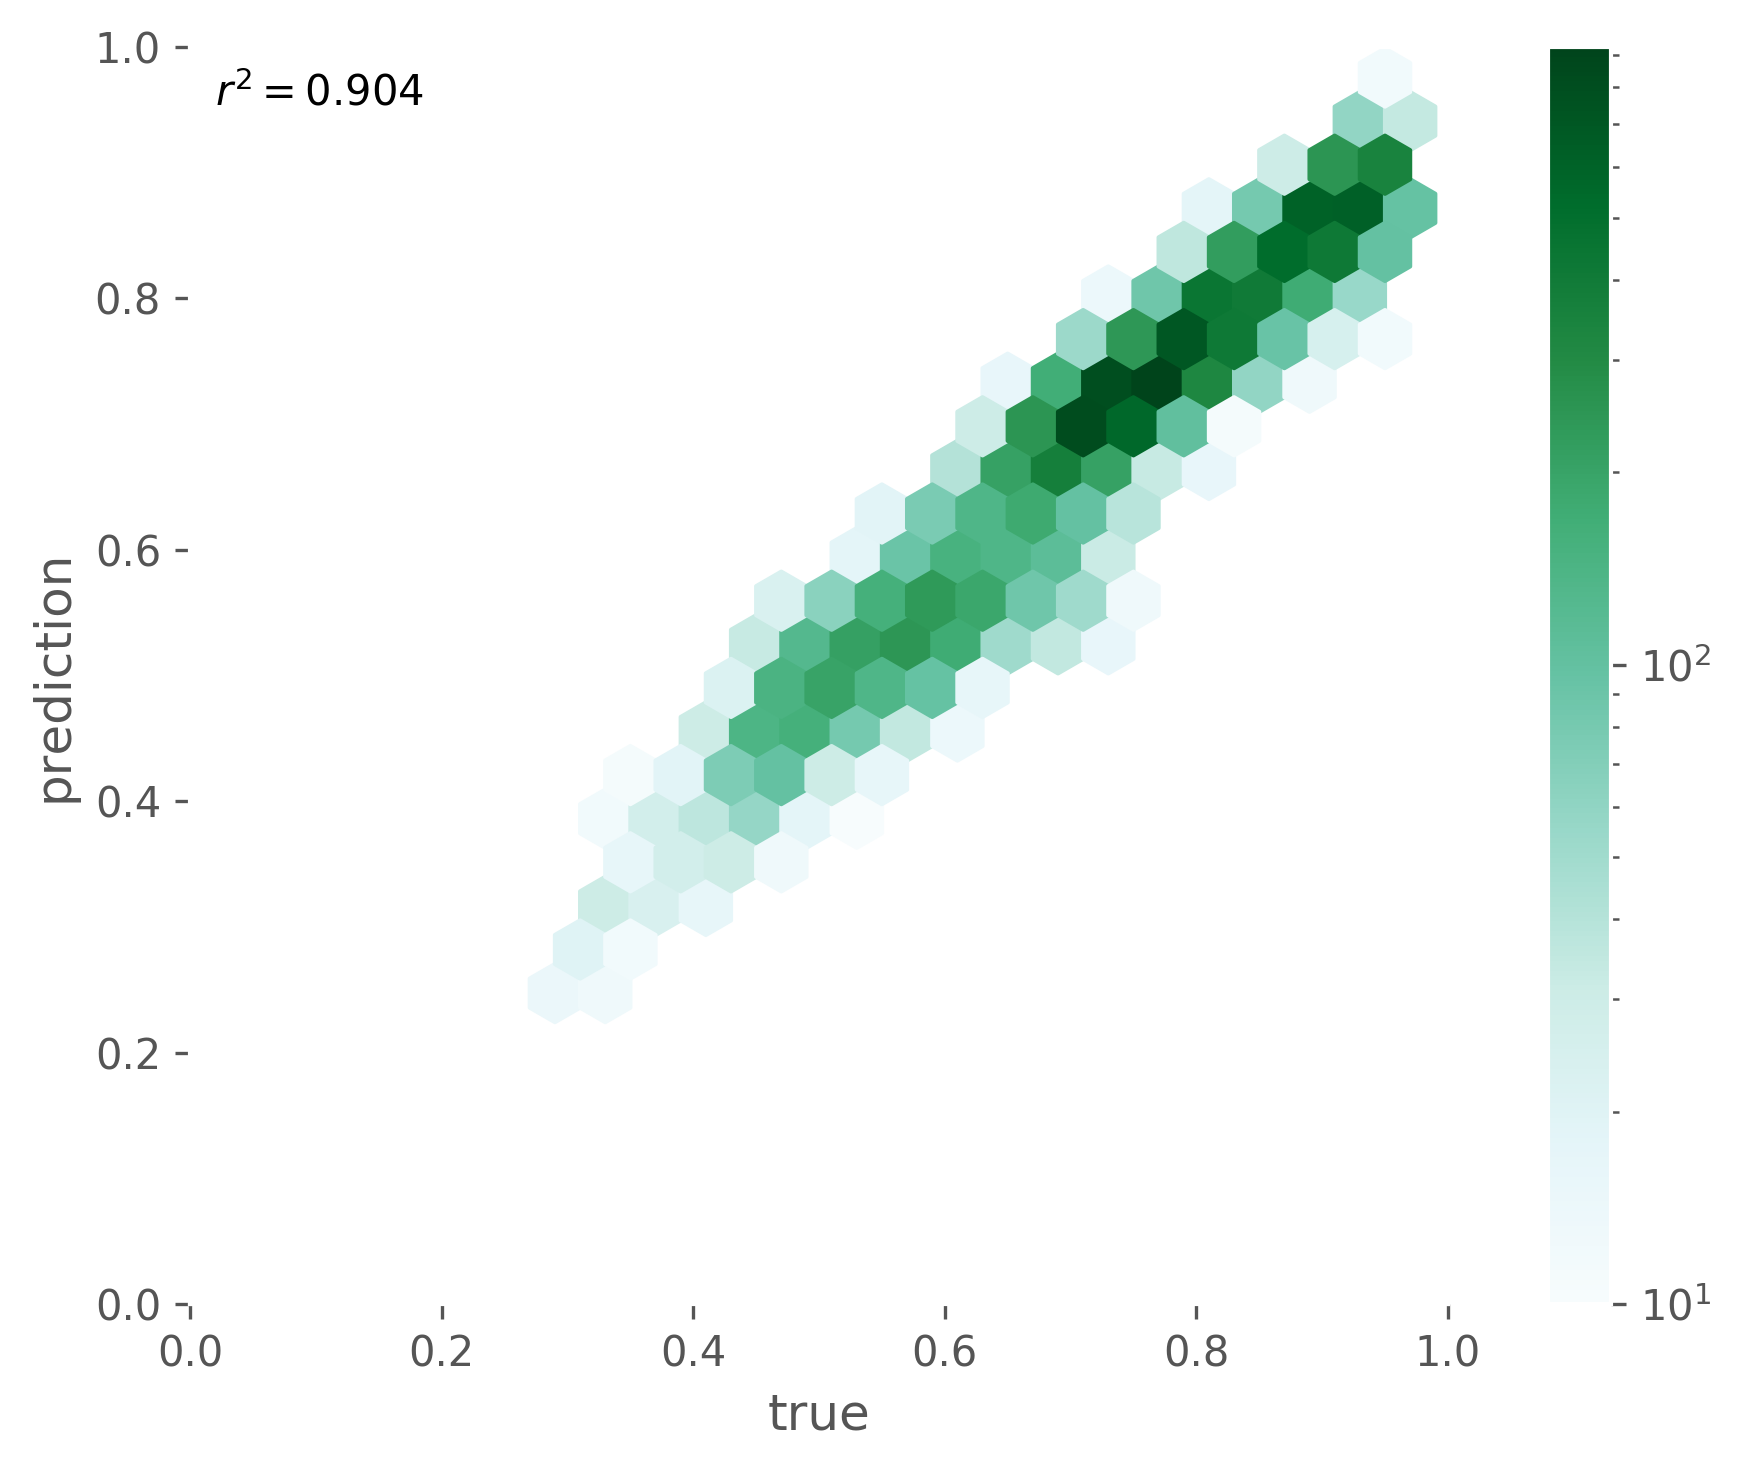

In [25]:
fig = plt.figure(figsize=(7, 5), dpi=300)
ax = fig.gca()

ax = df.plot.hexbin(
    x="true",
    y="prediction",
    extent=(-0.03, 1.01, -0.03, 1.01),
    xlim=(0, 1),
    ylim=(0, 1),
    sharex=False,
    gridsize=26,
    bins="log",
    mincnt=10,
    ax=ax,
)
ax.set_facecolor("w")
ax.set_aspect("equal")
ax.text(0.02, 0.98, r2_text, verticalalignment="top")

if predict_test_only:
    dataset_tag = "_testonly"
else:
    dataset_tag = ""

plt.tight_layout()


fig.savefig(
    filename + "_prediction" + dataset_tag + ".pdf",
    bbox_inches="tight",
    pad_inches=0,
)
fig.savefig(
    filename + "_prediction" + dataset_tag + ".png",
    bbox_inches="tight",
    pad_inches=0,
)